# MLP

In [37]:
from typing import List

In [1]:
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [172]:
import torch.nn.functional as F

## 1. Data Gathering

In [2]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

## 2. Data Pre-Processing

In [4]:
START = END = '.'
CHARS = sorted(list(set(''.join(words))) + [START])

stoi = {char:idx for idx, char in enumerate(CHARS)}
itos = {i:s for s, i in stoi.items()}

In [5]:
print(f"\n{CHARS=}")
print(f"\n{stoi=}")
print(f"\n{itos=}")


CHARS=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

itos={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 2.1 NGrams Split

In [56]:
def get_ngrams(words: List[str], ngrams=3, debug=False):
    X, Y = list(), list()
    
    for word in words:
        if debug: print(f"-- {word} --")
        context_idxs = [stoi[START]] * (ngrams-1)
        
        for char in word+END:
            pred_idx = stoi[char]
            Y.append(pred_idx)
            X.append(context_idxs)
            
            if debug: print(f"{''.join(itos[i] for i in context_idxs)} {itos[pred_idx]}")
            context_idxs = context_idxs[1:] + [pred_idx]
            
    return torch.tensor(X), torch.tensor(Y)

In [99]:
NGRAMS = 4
CONTEXT_SIZE = NGRAMS - 1

#### 2.1.1 Small Data

In [104]:
# TEST DATASET
X, Y = get_ngrams(words=words[:4], ngrams=NGRAMS, debug=True)

-- emma --
... e
..e m
.em m
emm a
mma .
-- olivia --
... o
..o l
.ol i
oli v
liv i
ivi a
via .
-- ava --
... a
..a v
.av a
ava .
-- isabella --
... i
..i s
.is a
isa b
sab e
abe l
bel l
ell a
lla .


In [101]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [ 0,  0,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0]))

#### 2.1.2 Large Data

In [200]:
# Complete Dataset

X, Y = get_ngrams(words=words, ngrams=NGRAMS, debug=False)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

## 3. MLP

### 3.1 Architecture
From paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

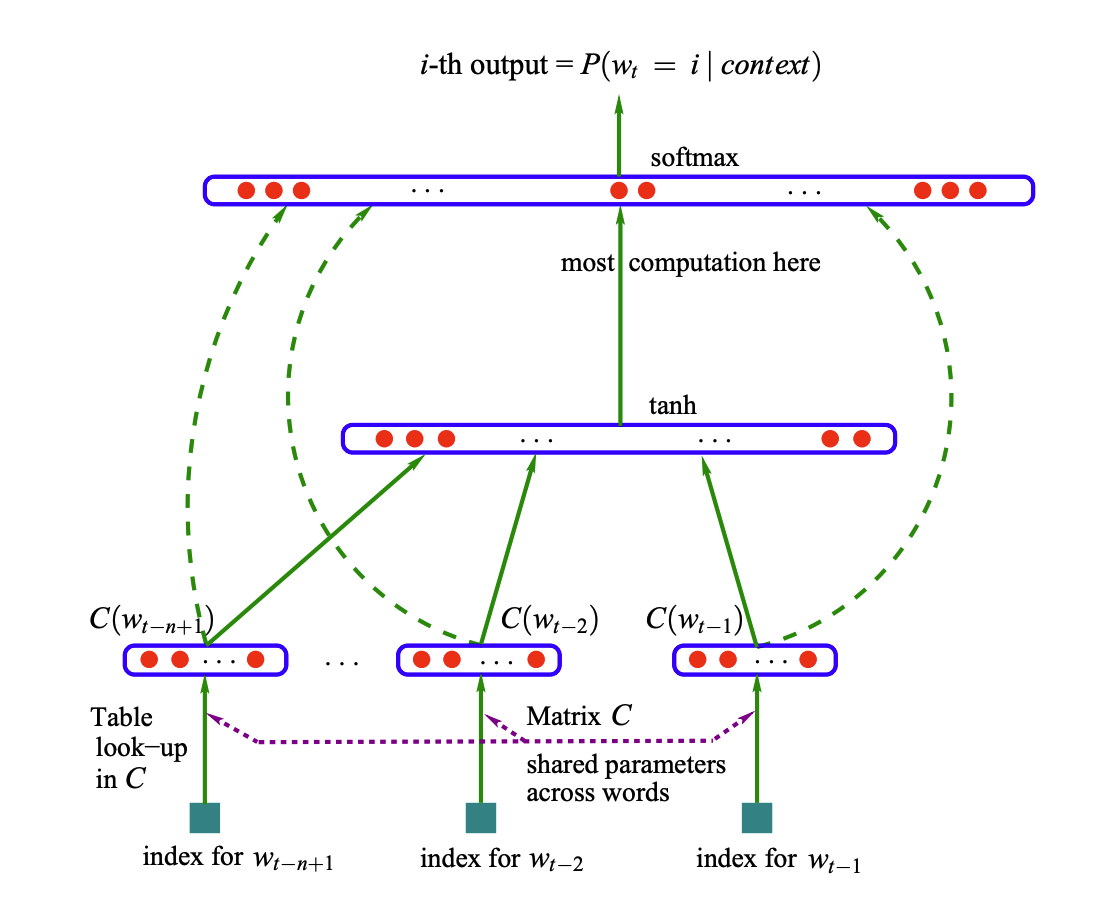

### 3.2 Word2Vec : Embedding

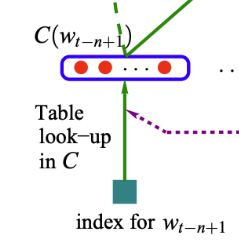

In [71]:
# Number embeddings vector size, i.e size of C. 
# translating 27 characters size to N_EMBEDS size for word2vec 

N_EMBEDS = 2      

In [105]:
C = torch.randn((len(CHARS), 2))
C.shape

torch.Size([27, 2])

In [106]:
# to get embeddings for char = 1
C[1]

tensor([0.1261, 0.5258])

In [107]:
# get first inputs embeding
X[0]

tensor([0, 0, 0])

In [108]:
C[torch.tensor([0, 0, 0])]

tensor([[0.8518, 1.0971],
        [0.8518, 1.0971],
        [0.8518, 1.0971]])

In [109]:
# alternatively, This is nothing but embeddings representation for 1st input.

C[X[0]]

tensor([[0.8518, 1.0971],
        [0.8518, 1.0971],
        [0.8518, 1.0971]])

In [110]:
# Doing for all the dataset,

emb = C[X]

emb.shape   # shape (N, CONTEXT_SIZE, N_EMBED)

torch.Size([25, 3, 2])

### 3.3 Hidden Linear FC Layer
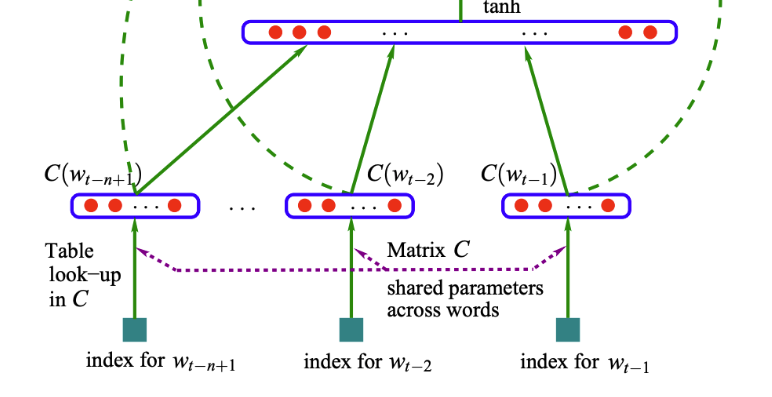

Interesting Blog post of working of pytorch tensors [here](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [113]:
# Fully connected nodes size
N_POSITIONS = 100

In [111]:
# Flatten the context words into one layer by concatenating.
# converting shape (N, CONTEXT_SIZE, N_EMBED) --> (N, CONTEXT_SIZE * N_EMBEDS)

emb = emb.view((emb.shape[0], -1))
emb.shape

torch.Size([25, 6])

In [115]:
# FC layer with shape (CONTEXT_SIZE * NEMBEDS, N_POSITIONS)

W1 = torch.randn((CONTEXT_SIZE*N_EMBEDS, N_POSITIONS))
b1 = torch.randn(N_POSITIONS)

In [116]:
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [123]:
# b1 is broadcasted

h = torch.tanh(emb @ W1 + b1)

torch.Size([25, 100])

### 3.4 Output FC layer
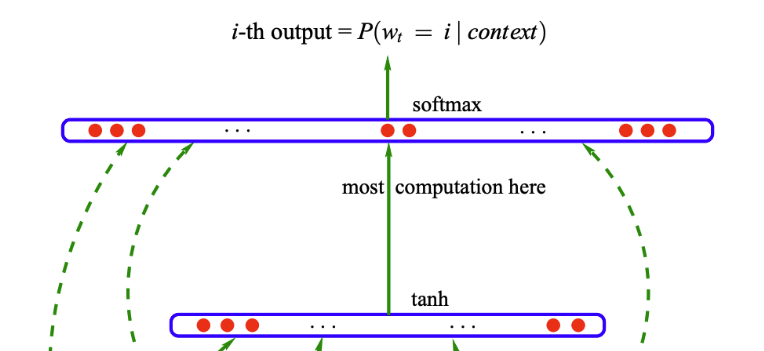

In [137]:
W2 = torch.randn((N_POSITIONS, len(CHARS)))
b2 = torch.randn((len(CHARS)))

W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [147]:
y_pred = torch.softmax(h @ W2 + b2, dim=-1)
y_pred.shape

torch.Size([25, 27])

In [149]:
y_pred[0]

tensor([3.3120e-06, 6.7327e-07, 4.2492e-10, 2.8181e-07, 1.3768e-06, 2.0194e-05,
        3.1719e-04, 8.9271e-12, 5.8814e-08, 5.3574e-11, 3.7687e-11, 6.0167e-09,
        6.8677e-07, 1.8247e-10, 6.8340e-16, 3.9613e-14, 1.4731e-10, 3.3360e-10,
        4.3462e-08, 2.1096e-08, 2.5094e-07, 1.3830e-09, 1.2043e-06, 1.5045e-04,
        5.5254e-10, 1.1545e-03, 9.9835e-01])

### 3.5 Cross Entropy Loss calculation

#### Method 1

In [170]:
logits = h @ W2 + b2

counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)

# -log(probability) / N
loss = -probs[(torch.arange(probs.shape[0]), Y)].log().mean()
loss

tensor(18.0808)

#### Method 2

In [171]:
probs = torch.softmax(h @ W2 + b2, dim=-1)

# -log(probability) / N
loss = -probs[(torch.arange(probs.shape[0]), Y)].log().mean()
loss

tensor(18.0808)

#### Method 3

In [173]:
logits = h @ W2 + b2

# Cross Entropy
loss = F.cross_entropy(logits, Y)
loss

tensor(18.0808)

### 3.6 Training Loop

#### 3.6.1 Simple Training loop

In [201]:
N_EMBEDS = 2 
N_POSITIONS = 100

EPOCHS = 100
LR = 0.1

In [202]:
# Model

# Seed for reproducibility
g = torch.Generator().manual_seed(4744)

# Embeding Layer
C = torch.randn((len(CHARS), N_EMBEDS), generator=g)    

# Hidden Layer
W1 = torch.randn((CONTEXT_SIZE * N_EMBEDS, N_POSITIONS), generator=g)
b1 = torch.randn((N_POSITIONS), generator=g)

# Output Layer
W2 = torch.randn((N_POSITIONS, len(CHARS)), generator=g)
b2 = torch.randn((len(CHARS)), generator=g)

# Parameters
parameters = [C, W1, b1, W2, b2]
print(f"Number of params: {sum(p.nelement() for p in parameters)}")

# Require Grads , for backprop
for p in parameters: p.requires_grad = True

Number of params: 3481


Dataset size: 228146


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Loss 1/100: 71.97122955322266
Loss 10/100: 10.416701316833496
Loss 20/100: 5.724425315856934
Loss 30/100: 4.705154895782471
Loss 40/100: 3.807725429534912
Loss 50/100: 3.873209238052368
Loss 60/100: 3.7820162773132324
Loss 70/100: 3.253653049468994
Loss 80/100: 3.5721077919006348
Loss 90/100: 3.2809624671936035
Loss 100/100: 3.073629856109619


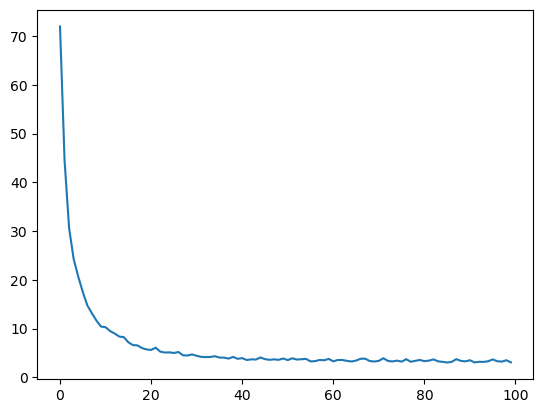

In [203]:
print(f"Dataset size: {len(X)}")

losses = list()

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    
    # Forward
    emb = C[X]                                  # C(CHARS, N_EMBEDS) X[N, CONTEXT_SIZE] --> emb(N, CONTEXT_SIZE, N_EMBEDS)
    h = emb.view(emb.shape[0], -1) @ W1 + b1    # emb.view(N, CONTEXT_SIZE*N_EMBEDS) @ W1 + b1 --> (N, N_POSITIONS)
    logits = h @ W2 + b2                        # --> logits(N, CHARS)
    loss = F.cross_entropy(logits, Y)
    if epoch in {0} or epoch % 10 == 9: print(f"Loss {epoch+1}/{EPOCHS}: {loss.item()}")
    losses.append(loss.item())
    
    # Backward
    for p in parameters: p.grad = None
    loss.backward()
    
    # Optimizer
    for p in parameters: p.data -= LR * p.grad
  
plt.plot(losses)

#### 3.6.2 Mini batch training

In [240]:
N_EMBEDS = 2 
N_POSITIONS = 100

BATCH_SIZE = 32
EPOCHS = 1000
LR = 0.1

In [241]:
# Model

# Seed for reproducibility
g = torch.Generator().manual_seed(4744)

# Embeding Layer
C = torch.randn((len(CHARS), N_EMBEDS), generator=g)    

# Hidden Layer
W1 = torch.randn((CONTEXT_SIZE * N_EMBEDS, N_POSITIONS), generator=g)
b1 = torch.randn((N_POSITIONS), generator=g)

# Output Layer
W2 = torch.randn((N_POSITIONS, len(CHARS)), generator=g)
b2 = torch.randn((len(CHARS)), generator=g)

# Parameters
parameters = [C, W1, b1, W2, b2]
print(f"Number of params: {sum(p.nelement() for p in parameters)}")

# Require Grads , for backprop
for p in parameters: p.requires_grad = True

Number of params: 3481


In [242]:
# generate random idxs, to pic datapoints in X
get_batch_idxs = lambda x: torch.randint(0, x.shape[0], size=(BATCH_SIZE,))

ix = get_batch_idxs(X)
ix

tensor([ 47470, 203371, 158857, 150764, 202743,  38422,  23599,  79153, 164385,
        168983,  38193, 227827,  91418,  84011, 133884, 142847, 136219, 198304,
         60310, 178989,  32018, 179933, 197854, 191608,  20237,  29346, 155434,
        176229, 178478,  36842,  89707, 104793])

Dataset size: 228146


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss 1/1000: 73.02877044677734
Loss 100/1000: 5.27194881439209
Loss 200/1000: 4.25439453125
Loss 300/1000: 3.136918306350708
Loss 400/1000: 2.8890864849090576
Loss 500/1000: 3.051440954208374
Loss 600/1000: 2.604431629180908
Loss 700/1000: 2.704911708831787
Loss 800/1000: 2.9255006313323975
Loss 900/1000: 2.7310242652893066
Loss 1000/1000: 2.6056158542633057


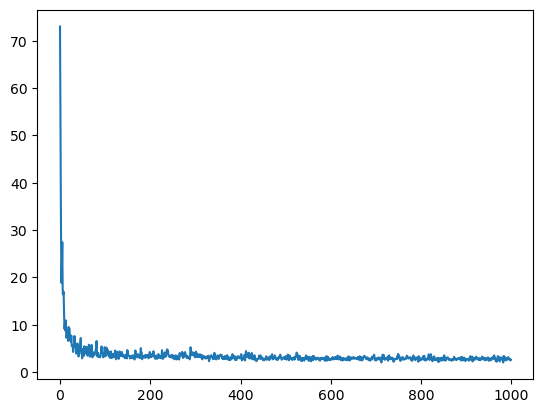

In [243]:
print(f"Dataset size: {len(X)}")

losses = list()

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    
    # Batch indexes
    ix = get_batch_idxs(X)
    _X = X[ix]
    _Y = Y[ix]
    
    # Forward
    emb = C[_X]                                 # C(CHARS, N_EMBEDS) X[N, CONTEXT_SIZE] --> emb(N, CONTEXT_SIZE, N_EMBEDS)
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)    # emb.view(N, CONTEXT_SIZE*N_EMBEDS) @ W1 + b1 --> (N, N_POSITIONS)
    logits = h @ W2 + b2                        # --> logits(N, CHARS)
    loss = F.cross_entropy(logits, _Y)
    if epoch in {0} or epoch % int(EPOCHS/10) == int(EPOCHS/10) - 1: print(f"Loss {epoch+1}/{EPOCHS}: {loss.item()}")
    losses.append(loss.item())
    
    # Backward
    for p in parameters: p.grad = None
    loss.backward()
    
    # Optimizer
    for p in parameters: p.data -= LR * p.grad
  
plt.plot(losses)

#### 3.6.3 Finding Best LR

In [249]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [250]:
# Model

# Seed for reproducibility
g = torch.Generator().manual_seed(4744)

# Embeding Layer
C = torch.randn((len(CHARS), N_EMBEDS), generator=g)    

# Hidden Layer
W1 = torch.randn((CONTEXT_SIZE * N_EMBEDS, N_POSITIONS), generator=g)
b1 = torch.randn((N_POSITIONS), generator=g)

# Output Layer
W2 = torch.randn((N_POSITIONS, len(CHARS)), generator=g)
b2 = torch.randn((len(CHARS)), generator=g)

# Parameters
parameters = [C, W1, b1, W2, b2]
print(f"Number of params: {sum(p.nelement() for p in parameters)}")

# Require Grads , for backprop
for p in parameters: p.requires_grad = True

Number of params: 3481


In [251]:
EPOCHS = len(lrs)

Dataset size: 228146


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss 1/1000: 77.83749389648438
Loss 100/1000: 37.82368469238281
Loss 200/1000: 17.937400817871094
Loss 300/1000: 7.987119197845459
Loss 400/1000: 6.573378086090088
Loss 500/1000: 3.2930541038513184
Loss 600/1000: 4.102162837982178
Loss 700/1000: 5.17586088180542
Loss 800/1000: 4.47496223449707
Loss 900/1000: 3.490363359451294
Loss 1000/1000: nan


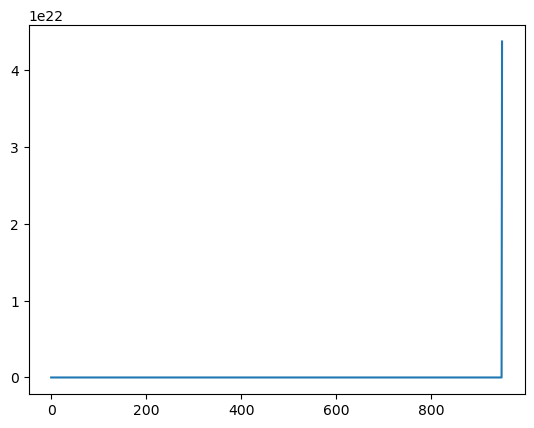

In [252]:
print(f"Dataset size: {len(X)}")

lrsi = list()
losses = list()

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    
    # Batch indexes
    ix = get_batch_idxs(X)
    _X = X[ix]
    _Y = Y[ix]
    
    # Forward
    emb = C[_X]                                 # C(CHARS, N_EMBEDS) X[N, CONTEXT_SIZE] --> emb(N, CONTEXT_SIZE, N_EMBEDS)
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)    # emb.view(N, CONTEXT_SIZE*N_EMBEDS) @ W1 + b1 --> (N, N_POSITIONS)
    logits = h @ W2 + b2                        # --> logits(N, CHARS)
    loss = F.cross_entropy(logits, _Y)
    if epoch in {0} or epoch % int(EPOCHS/10) == int(EPOCHS/10) - 1: print(f"Loss {epoch+1}/{EPOCHS}: {loss.item()}")
    losses.append(loss.item())
    lrsi.append(lrs[epoch])
    
    # Backward
    for p in parameters: p.grad = None
    loss.backward()
    
    # Optimizer
    lr = lrs[epoch]
    for p in parameters: p.data -= lr * p.grad
  
plt.plot(losses)

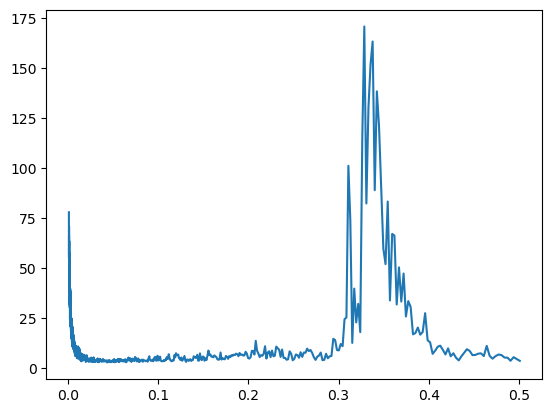

In [255]:
plt.plot(lrsi[:900], losses[:900])

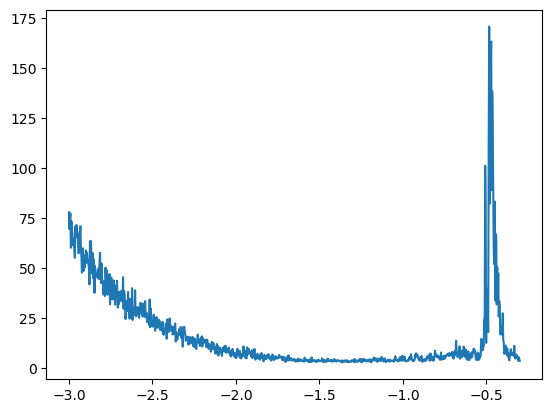

In [256]:
plt.plot(lre[:900], losses[:900])

In [268]:
#best LR
10**-1.3

0.05011872336272722

In [266]:
5e-2

0.05